# MyoPS 2020 Challenge


In [1]:
import torch
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from glob import glob
from pathlib import Path
import numpy as np
import os
from tqdm.notebook import tqdm
from fastai2.vision.all import PILImage, PILMask, image2tensor
import nibabel as nib

In [2]:
files = glob("../pred/multi_ce_full/raw/*.pt")
len(files), files[:10]

(174,
 ['../pred/multi_ce_full/raw/201-orig-4.pt',
  '../pred/multi_ce_full/raw/213-orig-2.pt',
  '../pred/multi_ce_full/raw/211-orig-2.pt',
  '../pred/multi_ce_full/raw/120-orig-1.pt',
  '../pred/multi_ce_full/raw/121-orig-1.pt',
  '../pred/multi_ce_full/raw/113-orig-1.pt',
  '../pred/multi_ce_full/raw/120-orig-5.pt',
  '../pred/multi_ce_full/raw/104-orig-3.pt',
  '../pred/multi_ce_full/raw/220-orig-2.pt',
  '../pred/multi_ce_full/raw/111-orig-1.pt'])

## Make ensemble predictions

In [3]:
def make_ensemble_pred(ce_file_name):
    f = ce_file_name
    # no softmax for ce predictions
    summary_pred = torch.load(f)
    for i in ['multi_patho.35_full', 'multi_edema.4_full', 'multi_scar.4_full']:
        summary_pred += torch.load(f.replace('multi_ce_full',i)).softmax(dim=0)
    # add class specific predictions
    summary_pred[4] += torch.load(f.replace('multi_ce_full','t2_edemaOnly.8_full')).softmax(dim=0)[1]
    summary_pred[5] += torch.load(f.replace('multi_ce_full','lge_scarOnly.8_full')).softmax(dim=0)[1]
    # normalize
    summary_pred = summary_pred/torch.Tensor([4,4,4,4,5,5]).view(-1,1,1)
    return summary_pred

In [4]:
def make_all_predictions():
    ids = np.concatenate((np.arange(101,126),np.arange(201,221)))
    outdir = f'../pred/ensemble'
    os.makedirs(f'{outdir}/nifti', exist_ok=True)
    os.makedirs(f'{outdir}/raw', exist_ok=True)
    rev_map = torch.LongTensor([0, 500, 200, 600, 1220, 2221])
    for id in tqdm(ids):
        origs = sorted(glob(f"../data/png/images/{id}-orig-*.png"))
        masks = []
        for o in origs:
            image = PILImage.create(o)
            pred = make_ensemble_pred(o.replace('data/png/images','pred/multi_ce_full/raw').replace('.png','.pt'))
            torch.save(pred, f'{outdir}/raw/{Path(o).name.replace("png","pt")}')
            mask = PILMask.create(pred.argmax(dim=0).byte()).rotate(180).crop_pad((image.shape[1],image.shape[0])).rotate(180)
            mask = rev_map.index_select(0,image2tensor(mask).flatten().to(torch.long)).reshape(*mask.shape)
            masks.append(mask.to(torch.int32))
        masks = np.stack(masks,axis=2)
        if(id<200):
            nifti = nib.load(f'../data/train25_myops_gd/myops_training_{id}_gd.nii.gz')
        else:
            nifti = nib.load(f'../data/test20/myops_test_{id}_C0.nii.gz')
        nifti_pred = nib.Nifti1Image(masks, nifti.affine, nifti.header)
        nib.save(nifti_pred, f'{outdir}/nifti/myops_test_{id}_seg.nii.gz')

In [5]:
make_all_predictions()

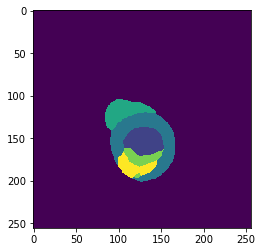

In [6]:
plt.imshow(make_ensemble_pred('../pred/multi_ce_full/raw/120-orig-1.pt').argmax(dim=0))

## Compare DICEs on training set

In [30]:
prediction = np.asanyarray(nib.load('../pred/ensemble/nifti/myops_test_101_seg.nii.gz').dataobj)
truth = np.asanyarray(nib.load('../data/train25_myops_gd/myops_training_101_gd.nii.gz').dataobj)

In [59]:
def my_dice(truth, prediction, threshold=1000, debug=False):
    dice = 1
    true_mask = truth > threshold
    pred_mask = prediction > threshold
    intersect_mask = true_mask & pred_mask
    true_count = true_mask.sum()
    pred_count = pred_mask.sum()
    inter_count = intersect_mask.sum()
    if (true_count + pred_count) > 0:
        dice = 2*inter_count/(true_count+pred_count)
    if debug:
        return dice, true_mask, pred_mask, intersect_mask
    return dice

In [66]:
def nib2array(f):
    return np.asanyarray(nib.load(f).dataobj)

def get_dices(prediction = 'ensemble'):
    sc_dices = []
    scEd_dices = []
    trueFiles = glob('../data/train25_myops_gd/myops_training_*_gd.nii.gz')
    for f in trueFiles:
        truth = nib2array(f)
        pred = nib2array(f.replace('data/train25_myops_gd',f'pred/{prediction}/nifti').replace('_training_','_test_').replace('_gd','_seg'))
        scEd_dices.append(my_dice(truth,pred,threshold=1000))
        sc_dices.append(my_dice(truth,pred,threshold=2000))
    return sc_dices, scEd_dices

In [68]:
ensemble_dices = get_dices('ensemble')
patho_dices = get_dices('multi_patho.35_full')

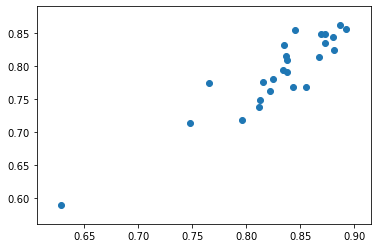

In [71]:
plt.scatter(ensemble_dices[0],patho_dices[0])

In [76]:
np.array(ensemble_dices).mean(axis=1)

array([0.8308286 , 0.87276063])

In [77]:
np.array(patho_dices).mean(axis=1)

array([0.7910287 , 0.80656612])

## Plot prob grid

In [241]:
def plot_prob_grid(pid=101, slice=0, gt=True):
    fig, axs = plt.subplots(7,7,figsize=(18,18))
    if gt:
        truth = PILMask.create(f"../data/png/masks/{pid}-orig-{slice}.png").crop_pad(256)
    else:
        truth = torch.zeros(256,256)
    for i in range(7):
        axs[i,0].imshow(truth, cmap="bone")
    for a in axs.flatten(): a.xaxis.set_visible(False)
    for a in axs.flatten(): a.yaxis.set_visible(False)
    f = f"../pred/multi_ce_full/raw/{pid}-orig-{slice}.pt"
    classes = [5,4,2,1,3]
    # no softmax for ce predictions
    pred = torch.load(f)
    axs[0,1].imshow(pred.argmax(dim=0), cmap="bone")
    for i, c in enumerate(classes):
        axs[0,i+2].imshow(pred[c])
    for i, p in enumerate(['multi_patho.35_full', 'multi_edema.4_full', 'multi_scar.4_full']):
        pred = torch.load(f.replace('multi_ce_full',p)).softmax(dim=0)
        axs[i+1,1].imshow(pred.argmax(dim=0), cmap="bone")
        for j, c in enumerate(classes):
            axs[i+1,j+2].imshow(pred[c])
    # add class specific predictions
    pred = torch.load(f.replace('multi_ce_full','t2_edemaOnly.8_full')).softmax(dim=0)
    axs[4,1].imshow(pred.argmax(dim=0), cmap="bone", norm=Normalize(0,1.25))
    axs[4,3].imshow(pred[1])
    #axs[4,7].imshow(pred[0])
    for i in [2,4,5,6]:
        axs[4,i].imshow(torch.zeros(256,256))
        axs[4,i].annotate("Not predicted", xy=(128,128), ha="center", color="white")
    pred = torch.load(f.replace('multi_ce_full','lge_scarOnly.8_full')).softmax(dim=0)
    axs[5,1].imshow(pred.argmax(dim=0), cmap="bone")
    axs[5,2].imshow(pred[1])
    #axs[5,7].imshow(pred[0])
    for i in [3,4,5,6]:
        axs[5,i].imshow(torch.zeros(256,256))
        axs[5,i].annotate("Not predicted", xy=(128,128), ha="center", color="white")
    pred = torch.load(f.replace('multi_ce_full','ensemble'))
    axs[6,1].imshow(pred.argmax(dim=0), cmap="bone")
    for i, c in enumerate(classes):
        axs[6,i+2].imshow(pred[c])
    # set titles
    for ax, col in zip(axs[0], ['truth','prediction','scar','edema','myocardium','LV','RV','background']):
        ax.set_title(col)
    for ax, row in zip(axs[:,0], ['ce','patho','multiEd','multiSc','edOnly','scOnly','ensemble']):
        ax.annotate(row, xy=(-1, 128),#, xytext=(-ax.yaxis.labelpad - 5, 0),
                #xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    plt.tight_layout()

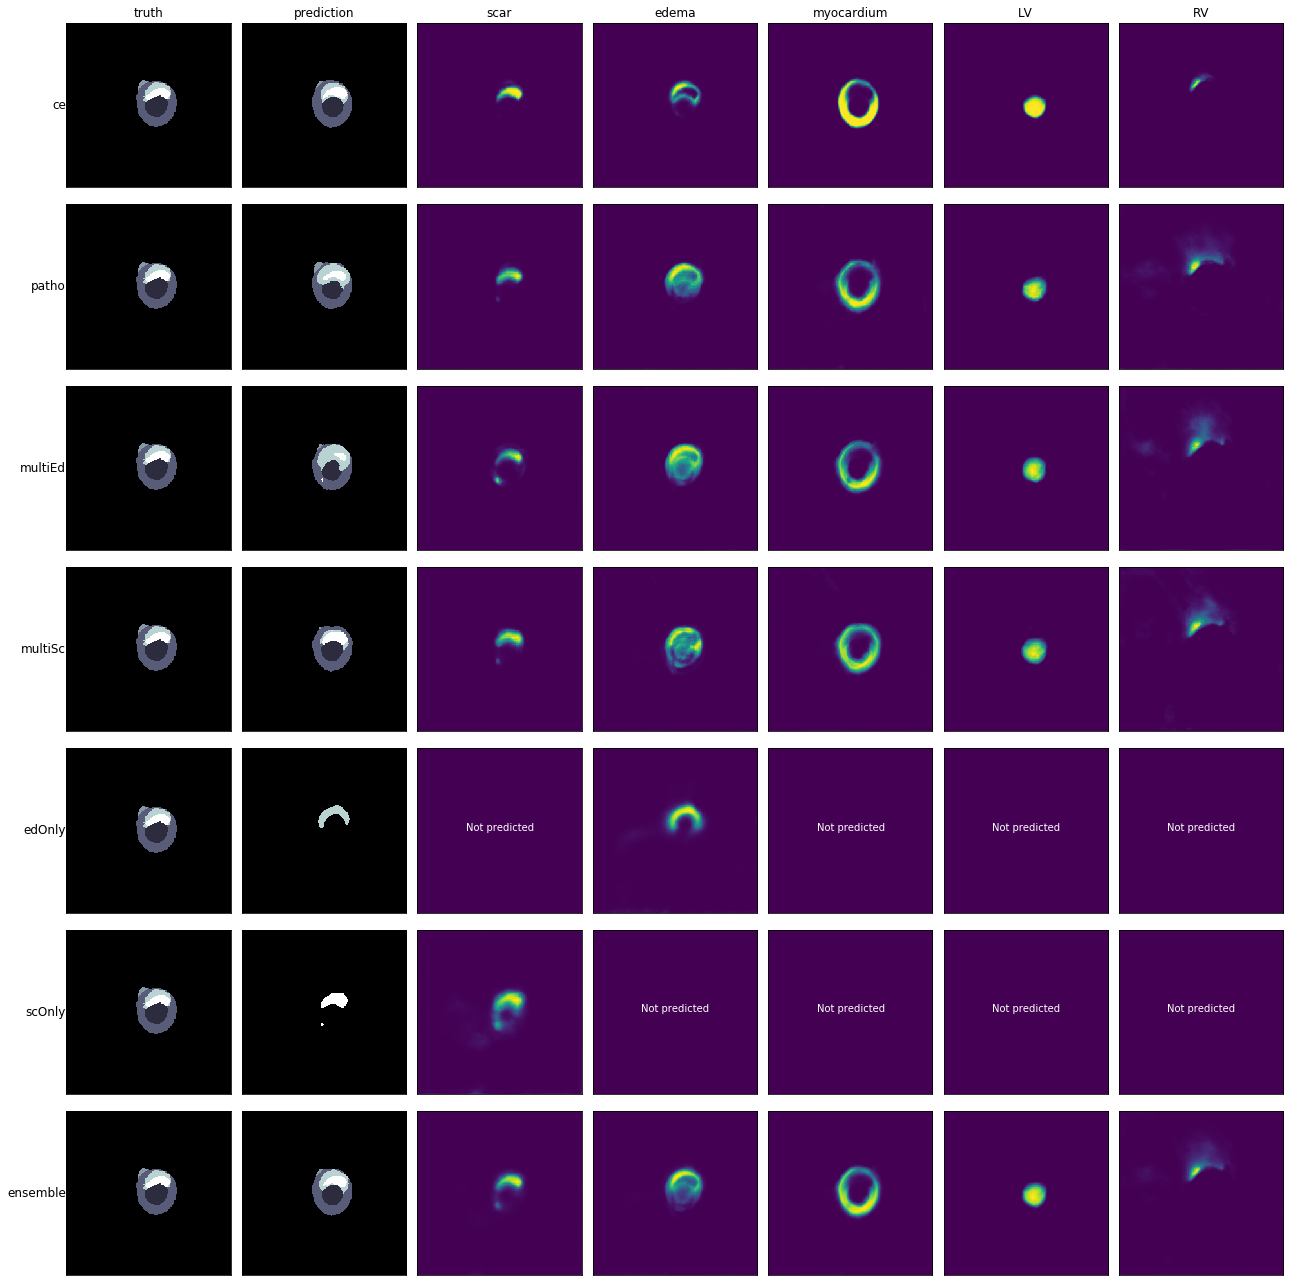

In [242]:
plot_prob_grid(101,0)

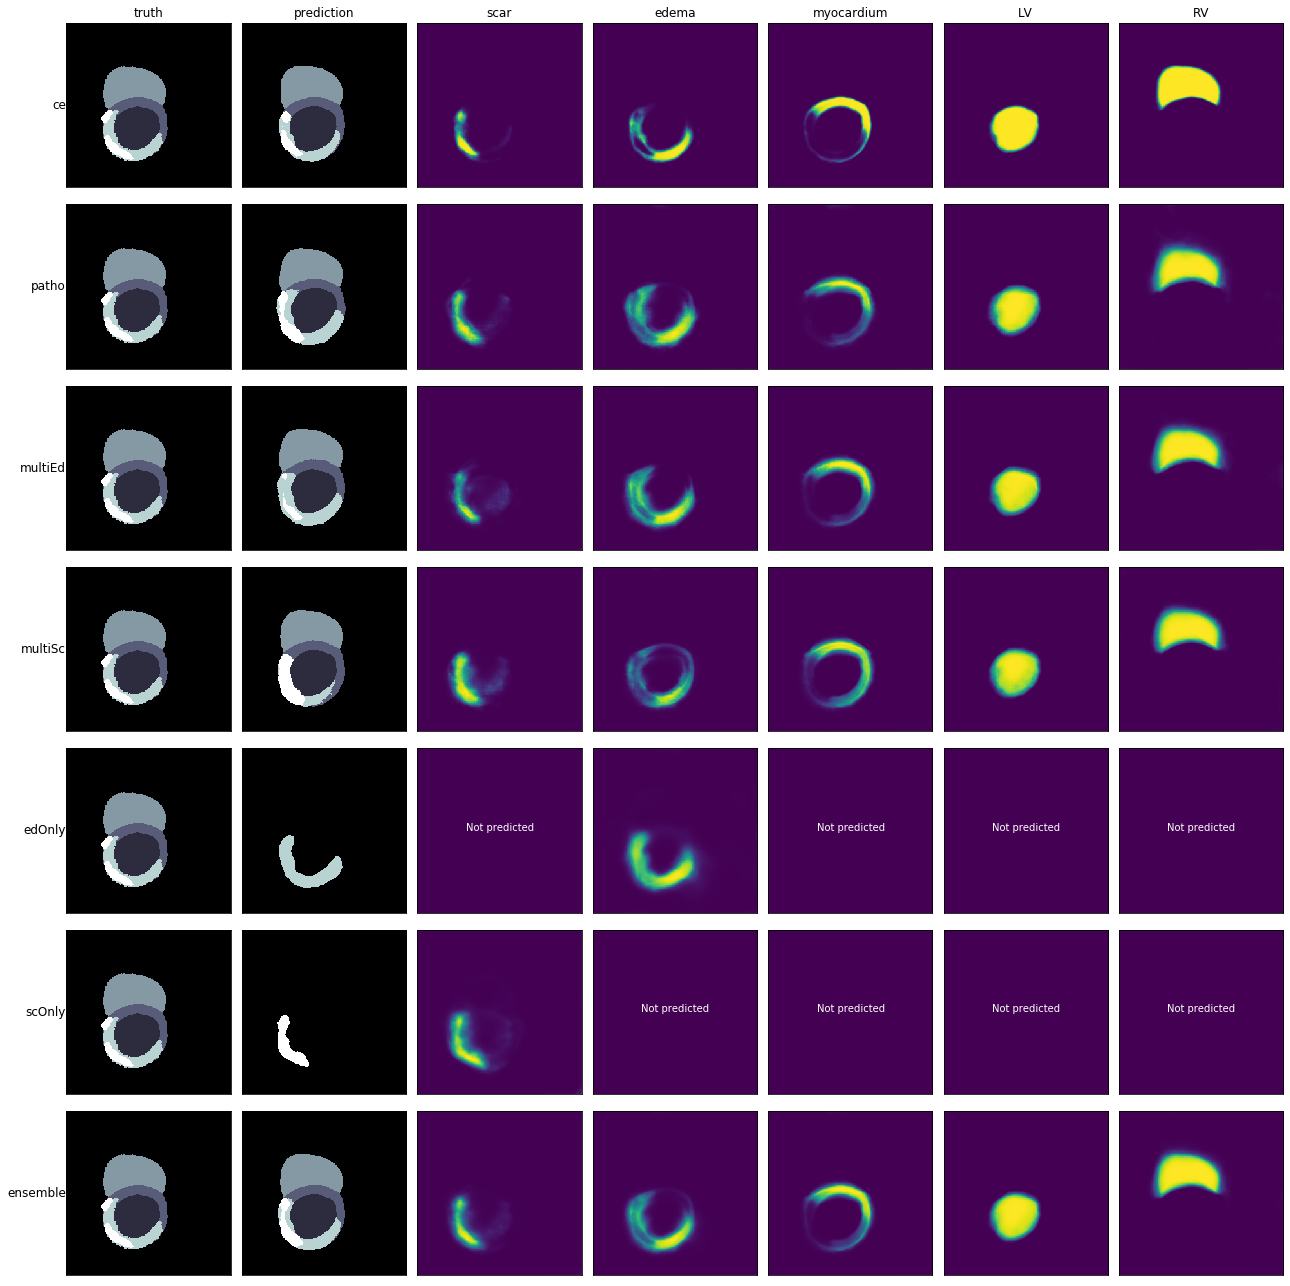

In [243]:
plot_prob_grid(102,1)

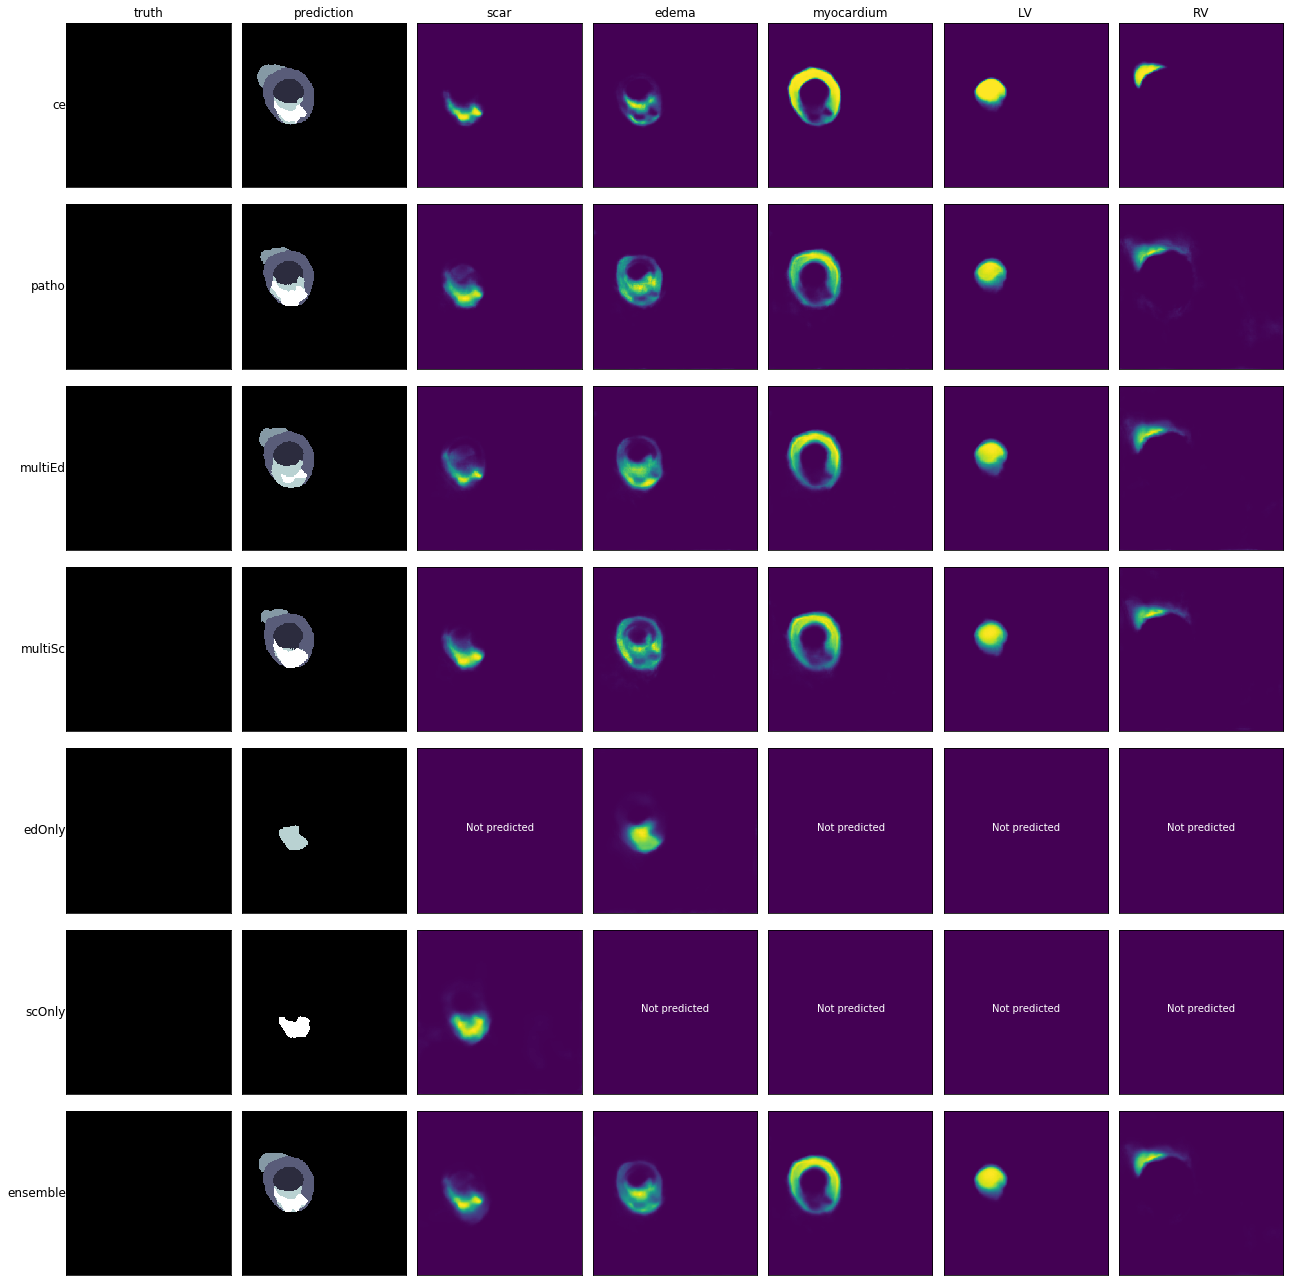

In [248]:
plot_prob_grid(206,1,gt=False)

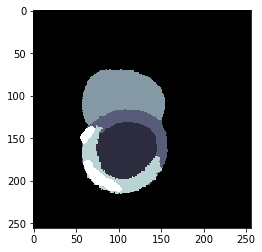

In [175]:
plt.imshow(PILMask.create("../data/png/masks/102-orig-1.png").crop_pad(256), cmap="bone")

## Experiments

In [78]:
preds = glob("../pred/*/raw/*101*-0.pt")

In [79]:
preds

['../pred/t2_edemaOnly.8_full/raw/101-orig-0.pt',
 '../pred/multi_scar.4_full/raw/101-orig-0.pt',
 '../pred/multi_patho.35_full/raw/101-orig-0.pt',
 '../pred/multi_ce_full/raw/101-orig-0.pt',
 '../pred/lge_scarOnly.8_full/raw/101-orig-0.pt',
 '../pred/multi_edema.4_full/raw/101-orig-0.pt',
 '../pred/ensemble/raw/101-orig-0.pt']

In [80]:
preds_c = []
for x in preds:
    pred = torch.load(x).argmax(dim=0).numpy()
    if "edemaOnly" in x:
        pred = pred * 4
    if "scarOnly" in x:
        pred = pred * 5
    preds_c.append(pred)

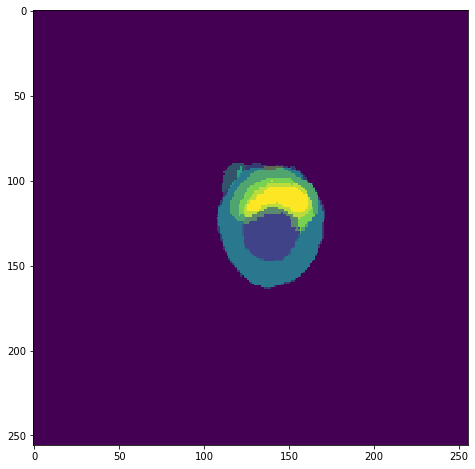

In [81]:
fig, axs = plt.subplots(figsize=(8,8))
axs.imshow(preds_c[1])
axs.imshow(preds_c[2], alpha=.5)

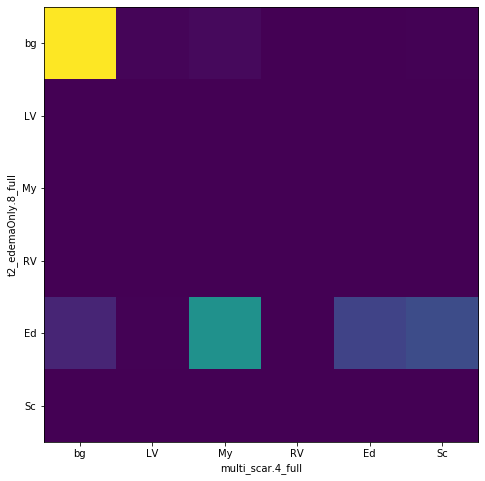

In [82]:
fig, axs = plt.subplots(figsize=(8,8))
_ = axs.imshow(confusion_matrix(preds_c[0].flatten(), preds_c[1].flatten(), normalize="true"))
_ = plt.xticks(range(6), labels=['bg','LV','My','RV','Ed','Sc'])
_ = plt.yticks(range(6), labels=['bg','LV','My','RV','Ed','Sc'])
_ = plt.xlabel(Path(preds[1]).parent.parent.name)
_ = plt.ylabel(Path(preds[0]).parent.parent.name)

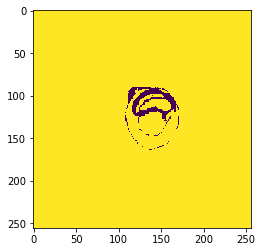

In [83]:
plt.imshow(preds_c[1] == preds_c[2])

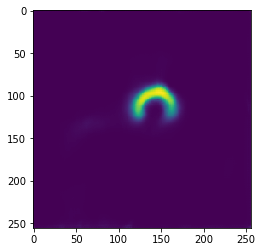

In [84]:
plt.imshow(torch.load(preds[0]).softmax(dim=0)[1])# * preds_c[0])

In [89]:
preds

['../pred/t2_edemaOnly.8_full/raw/101-orig-0.pt',
 '../pred/multi_scar.4_full/raw/101-orig-0.pt',
 '../pred/multi_patho.35_full/raw/101-orig-0.pt',
 '../pred/multi_ce_full/raw/101-orig-0.pt',
 '../pred/lge_scarOnly.8_full/raw/101-orig-0.pt',
 '../pred/multi_edema.4_full/raw/101-orig-0.pt',
 '../pred/ensemble/raw/101-orig-0.pt']

In [104]:
from matplotlib.colors import Normalize

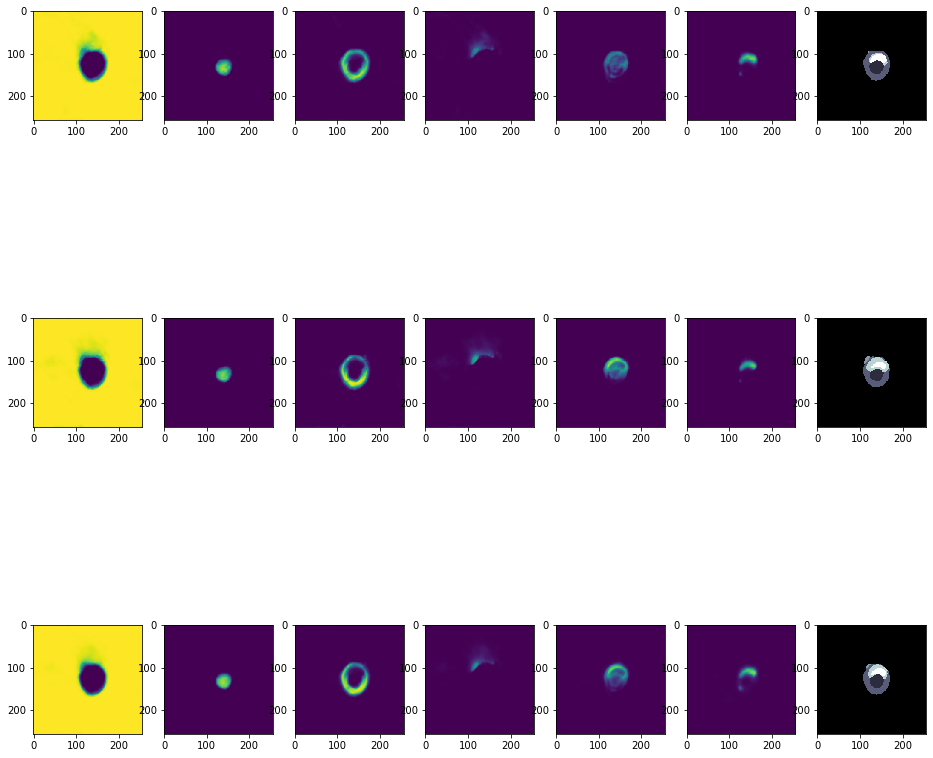

In [106]:
fig, axs = plt.subplots(3, 7, figsize=(16,16))
for j,bla in enumerate([1,2,6]):
    for i in range(6):
        if j>1:
            axs[j,i].imshow(torch.load(preds[bla])[i], norm=Normalize(vmin=0, vmax=1))
        else:
            axs[j,i].imshow(torch.load(preds[bla]).softmax(dim=0)[i], norm=Normalize(vmin=0, vmax=1))
    axs[j,6].imshow(torch.load(preds[bla]).softmax(dim=0).argmax(dim=0), cmap="bone")

In [98]:
for j,bla in enumerate([1,2,6]):
    for i in range(6):
        print(torch.load(preds[bla]).softmax(dim=0)[i].max())

tensor(1.0000)
tensor(0.8829)
tensor(0.9068)
tensor(0.4926)
tensor(0.4897)
tensor(0.8326)
tensor(1.)
tensor(0.8291)
tensor(0.9764)
tensor(0.6489)
tensor(0.8435)
tensor(0.7953)
tensor(0.3522)
tensor(0.3167)
tensor(0.3404)
tensor(0.2402)
tensor(0.2911)
tensor(0.3052)


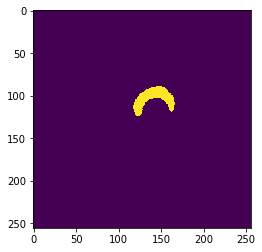

In [16]:
plt.imshow(preds_c[0])

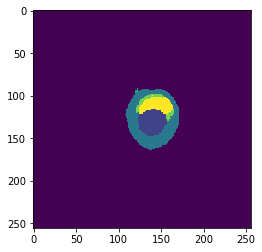

In [17]:
plt.imshow(preds_c[1])

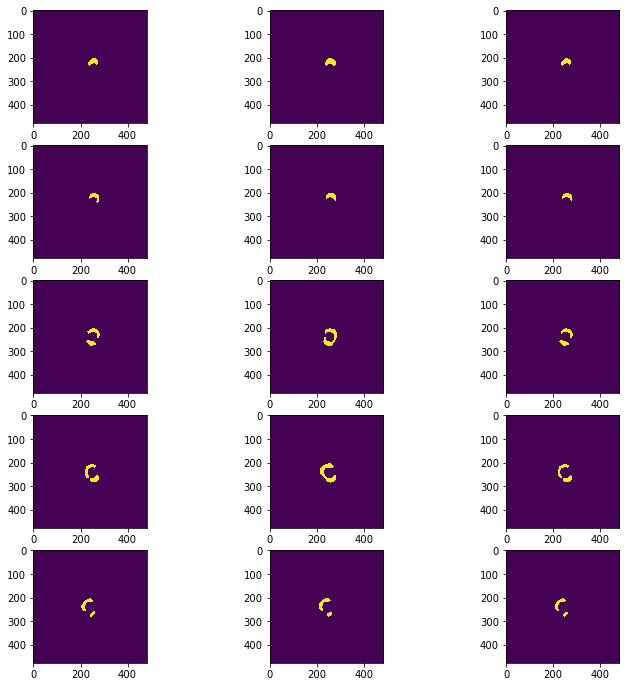

In [60]:
fig, axs = plt.subplots(5,3, figsize=(12,12))
tmp = my_dice(truth, prediction, debug=True)
for j in range(5):
    _=[axs[j,i].imshow(tmp[i+1][:,:,j]) for i in range(3)]

### Test broadcasting

In [18]:
tmp = torch.ones((3,5,5)) / torch.Tensor([2,2,3]).view(-1,1,1)
tmp

tensor([[[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

        [[0.3333, 0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333, 0.3333]]])

In [19]:
tmp[1] += tmp[2]
tmp

tensor([[[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

        [[0.8333, 0.8333, 0.8333, 0.8333, 0.8333],
         [0.8333, 0.8333, 0.8333, 0.8333, 0.8333],
         [0.8333, 0.8333, 0.8333, 0.8333, 0.8333],
         [0.8333, 0.8333, 0.8333, 0.8333, 0.8333],
         [0.8333, 0.8333, 0.8333, 0.8333, 0.8333]],

        [[0.3333, 0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333, 0.3333]]])